In [2]:
import re
import os
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from pprint import pprint
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.linalg import svd

# Split speech in sentences

### Speeches to sentences with labels

In [3]:
path1 = r"Talerne\Margrethe"
path2 = r"Talerne\Statsministeren"

def sentence_and_label(path):

    sentences = {}

    for file in os.listdir(path):
        filename = os.path.join(path, file)

        # Label the sentence
        if "Margrethe" in file:
            label = 0
        else:
            label = 1

        with open(filename, encoding='utf-8') as speech:
            speech = speech.read()
        
        speech = re.sub("[,*\"'-]"," ",speech)

        speech = speech.lower()

        tokens = nltk.sent_tokenize(speech, language="danish")

        for sentence in tokens:
            sentence = re.sub("[.:;?!`–”«»%…‘’/()]"," ",sentence) 
            sentence = sentence.strip() # Uden mellemrum forrest eller bagerst
            sentences[sentence] = label
        
    return sentences

Margrethe_sentences_with_labels = sentence_and_label(path1)
Statsministeren_sentences_with_labels = sentence_and_label(path2)

In [3]:
# from pprint import pprint

# # Pretty-print to look nice
# pprint(Margrethe_sentences_with_labels)
# pprint(Statsministeren_sentences_with_labels)


In [ ]:
all_sentences = Margrethe_sentences_with_labels | Statsministeren_sentences_with_labels
# pprint(all_sentences)
print(len(all_sentences))

10731


In [5]:
# # Inspect the tokens that look suspicious
# for sentence in all_sentences:
#     tokens = word_tokenize(sentence)
#     # Look for weird tokens
#     weird_tokens = [t for t in tokens if not t.isalnum()]
#     if weird_tokens:
#         print("Weird tokens found:", weird_tokens)

### Separate keys and values into two lists (For vectorization)

In [6]:
sentences_list = []
labels_list = []

for sentence in all_sentences:
    sentences_list.append(sentence)
    labels_list.append(all_sentences[sentence])

# print(sentences_list)
# print(labels_list)

In [7]:
print(len(sentences_list))

10731


### Split data into training and testing:

https://www.geeksforgeeks.org/how-to-split-data-into-training-and-testing-in-python-without-sklearn/

In [19]:
df = pd.DataFrame({
    "Sentences": sentences_list,
    "Labels": labels_list,
})
df

,Sentences,Labels
0,for min familie og for mig selv blev dette år ...,0
1,den dybe sorg der ramte os følte vi at hele...,0
2,de hjertelige følelser som i de tunge dage st...,0
3,1972 vil blive et historisk år på mange måder,0
4,i danmarkshistorien vil året blive husket for ...,0
...,...,...
10726,jeg tror desværre at de kommende år vil byde ...,1
10727,oprustning for at undgå krig er i mine øjne uo...,1
10728,men lad os gøre det på den danske måde,1
10729,socialt retfærdigt og med vores værdier i behold,1


In [20]:
# Shuffle dataframe using sample function
df = df.sample(frac=1)
df

,Sentences,Labels
10702,sygeplejerskerne vender tilbage og ventetider...,1
8347,og vi passer på hinanden,1
10124,vi skal stå fast på vores værdier,1
1787,måske var vi bedre til at forstå det dengang ...,0
7062,vi skal have sygehuse af højeste kvalitet,1
...,...,...
5548,vi må udnytte alle muligheder for at presse pa...,1
9900,dengang manglede det danmark som vi har nu,1
586,vi skal passe på at vi ikke af misforstået be...,0
5277,men også utrolige fremskridt i forskning og vi...,1


In [21]:
# Select ratio
ratio = 0.75
 
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
train = df[0:train_size]
test = df[train_size:]

In [22]:
# print train set
print("Train dataframe")
print(train)
 
# print test set
print("Test dataframe")
print(test)

Train dataframe
                                               Sentences  Labels
10702  sygeplejerskerne vender tilbage  og ventetider...       1
8347                            og vi passer på hinanden       1
10124                  vi skal stå fast på vores værdier       1
1787   måske var vi bedre til at forstå det  dengang ...       0
7062           vi skal have sygehuse af højeste kvalitet       1
...                                                  ...     ...
6294   jeg vil gerne have et danmark  der ganske enke...       1
3525          i mangelsamfundet var det en naturlig ting       1
9992   vi vil blandt andet fjerne modregningen i pens...       1
7907                                det forstår jeg godt       1
3138   det er noget  der styrker os alle sammen både ...       0

[8048 rows x 2 columns]
Test dataframe
                                              Sentences  Labels
9546                     det gør enhver svær beslutning       1
4190  1979 gjorde  at vi kom lidt i 

In [23]:
train_sentences = train['Sentences'].tolist()
train_labels = train["Labels"].tolist()

test_sentences = test['Sentences'].tolist()
test_labels = test["Labels"].tolist()

Tjekke samme anddel statsministertaler i begge datasæt:

In [24]:
sum(train_labels)/len(train_labels)

0.6937127236580517

In [25]:
sum(test_labels)/len(test_labels)

0.6962355572120761

### Gemmer de 2 dataframes i csv:

In [ ]:
train.to_csv("train_dataframe",sep=",")

In [ ]:
test.to_csv("train_dataframe",sep=",")

# UNIGRAM

Kun for træningssætninger!

In [26]:
unigram_dict = {}
unigram_set = set()
unigram_nt = {}

for sentence in train_sentences:
    # tokens i den givne sætning
    sentence_tokens = [word for word in word_tokenize(sentence)]

    # hvilke unigrams, der er blevet set i den givne sætning
    seen_unigrams = set()

    for unigram in sentence_tokens:
        if unigram in unigram_set:
            unigram_dict[unigram] += 1
        else:
            unigram_dict[unigram] = 1
            unigram_set.add(unigram)
     
        # Udregn nt - dvs antal af alle sætninger, der indeholder det givne unigram
        if unigram not in seen_unigrams:
            if unigram not in unigram_nt:
                unigram_nt[unigram] = 1
            else:
                unigram_nt[unigram] += 1
            seen_unigrams.add(unigram)

print(len(unigram_dict))
# print(unigram_dict)
# print(unigram_nt)

9972


In [9]:
# pprint(unigram_dict)

In [27]:
unigram_dict_forkortet = {}

# adder kun de unigrams, der er blevet talt mere end 1 gang.
for unigram in unigram_dict.keys():
    if unigram_dict[unigram] > 1:
        unigram_dict_forkortet[unigram] = unigram_dict[unigram] 

# unigram_dict_forkortet

In [28]:
len(unigram_dict_forkortet)

4682

# BIGRAM

Kun for træningssætninger!

In [29]:
bigram_dict = {}
bigram_set = set()
bigram_nt = {}

# print(bigram_nt)

for sentence in train_sentences:
    sentence_tokens = [word for word in word_tokenize(sentence)]
    seen_bigrams = set()

    for i in range(len(sentence_tokens)-1):
        bigram = sentence_tokens[i] + ' ' + sentence_tokens[i+1]
        if bigram in bigram_set:
            bigram_dict[bigram] += 1
        else:
            bigram_dict[bigram] = 1
            bigram_set.add(bigram)
    
    # Udregn nt
        if bigram not in seen_bigrams:
            if bigram not in bigram_nt:
                bigram_nt[bigram] = 1
            else:
                bigram_nt[bigram] += 1
            seen_bigrams.add(bigram)

# print(bigram_nt)

In [30]:
len(bigram_dict)

49105

In [14]:
# bigram_dict

In [31]:
bigram_dict_forkortet = {}

for bigram in bigram_dict.keys():
    if bigram_dict[bigram] > 1:
        bigram_dict_forkortet[bigram] = bigram_dict[bigram] 

# bigram_dict_forkortet

In [32]:
len(bigram_dict_forkortet)

11806

# TRIGRAM

Kun for træningssætninger!

In [33]:
trigram_dict = {}
trigram_set = set()
trigram_nt = {}

for sentence in train_sentences:
    sentence_tokens = [word for word in word_tokenize(sentence)]
    seen_trigrams = set()

    for i in range(len(sentence_tokens)-2):
        trigram = sentence_tokens[i] + ' ' + sentence_tokens[i+1] + ' ' + sentence_tokens[i+2]
        if trigram in trigram_set:
            trigram_dict[trigram] += 1
        else:
            trigram_dict[trigram] = 1
            trigram_set.add(trigram)

        # udregn nt
        if trigram not in seen_trigrams:
            if trigram not in trigram_nt:
                trigram_nt[trigram] = 1
            else:
                trigram_nt[trigram] += 1
            seen_trigrams.add(trigram)


# print(trigram_nt)

In [18]:
# trigram_dict

In [34]:
len(trigram_dict) # finder 4000 flere trigrams end sklearn???

78429

In [35]:
trigram_dict_forkortet = {}

for trigram in trigram_dict.keys():
    if trigram_dict[trigram] > 1:
        trigram_dict_forkortet[trigram] = trigram_dict[trigram] 

# trigram_dict_forkortet

In [36]:
len(trigram_dict_forkortet)

8254

# ALLE I ÉN LISTE

Kun for træningssætninger!

In [37]:
len(unigram_dict_forkortet) + len(bigram_dict_forkortet) + len(trigram_dict_forkortet)

24742

In [38]:
n_gram_dict = unigram_dict_forkortet | bigram_dict_forkortet | trigram_dict_forkortet

In [24]:
# pprint(n_gram_dict)

In [39]:
len(n_gram_dict)

24742

In [40]:
alle_nt = unigram_nt | bigram_nt | trigram_nt

# Document-term matrix:

Kun for træningssætninger!

In [42]:
n_gram_keys_list = [key for key in n_gram_dict.keys()]

In [28]:
# sentences_list

In [41]:
document_term_matrix = np.empty((len(train_sentences),len(n_gram_keys_list)),dtype='uint8')

for i in range(len(train_sentences)):
    for j in range(len(n_gram_keys_list)):
        count = train_sentences[i].count(n_gram_keys_list[j])
        document_term_matrix[i,j] = count
        
document_term_matrix

NameError: name 'n_gram_keys_list' is not defined

In [30]:
document_term_matrix.shape

(10731, 32418)

In [31]:
# document_term_matrix.to_string()

In [43]:
document_term_matrix_df = df = pd.DataFrame(data = document_term_matrix,  
                  index = train_sentences,  
                  columns = n_gram_keys_list) 
document_term_matrix_df

NameError: name 'document_term_matrix' is not defined

# TF-IDF matrix:

Kun for træningssætninger!

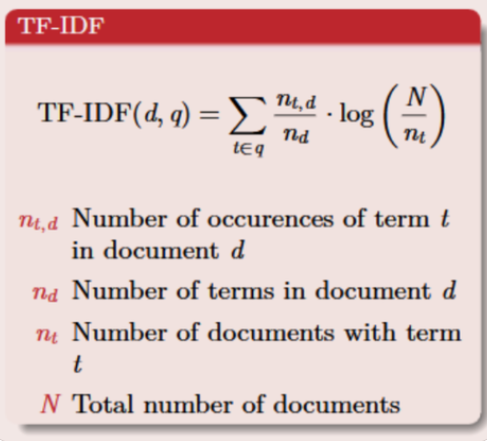

In [33]:
document_term_idf_matrix = np.empty((len(train_sentences),len(n_gram_keys_list)))

for i in range(len(train_sentences)):
    # print(train_sentences[i])
    tokens = train_sentences[i].split(" ")
    # print(tokens)
    for j in range(len(n_gram_keys_list)):
        term = n_gram_keys_list[j]
        ntd = train_sentences[i].count(term)
        nd = len(tokens)
        nt = alle_nt[term]
        tf_idf = (ntd/nd) * math.log(len(train_sentences)/nt)

        # print(term,ntd,nd,nt,math.log(len(train_sentences)/nt),tf_idf)

        # smooth idf: 
        # print(math.log((1 + len(train_sentences)) / (1 + nt)) + 1)

        document_term_idf_matrix[i, j] = tf_idf

document_term_idf_matrix

array([[0.15708063, 0.40776003, 0.23737934, ..., 0.        , 0.        ,
        0.        ],
       [0.0261801 , 0.20388001, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09684301, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [34]:
document_term_idf_matrix.shape

(10731, 32418)

In [35]:
# document_term_idf_matrix.to_string()

In [36]:
document_term_idf_matrix_df = pd.DataFrame(data = document_term_idf_matrix,  
                  index = train_sentences,  
                  columns = n_gram_keys_list) 
document_term_idf_matrix_df

,for,min,familie,og,mig,selv,blev,dette,år,skelsættende,...,de befolkninger i,befolkninger i verden,uanset hvad der,er historien om,vi bevæger os,bevæger os fremad,med de seneste,og hvis du,man siger at,år vil byde
for min familie og for mig selv blev dette år skelsættende ved min fader kong frederiks sygdom og død,0.157081,0.407760,0.237379,0.099851,0.208826,0.17446,0.201121,0.243523,0.131630,0.379024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
den dybe sorg der ramte os følte vi at hele folket tog del i og jeg kan ikke begynde denne min første nytårshilsen uden at bringe en tak for al den varme og sympati som blev prins henrik og mig men ikke mindst min moder dronning ingrid til del,0.026180,0.203880,0.000000,0.066567,0.069609,0.00000,0.067040,0.000000,0.043877,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
de hjertelige følelser som i de tunge dage støttede og løftede os har jeg siden i årets løb mødt så mange gange og det har været mig en glæde og inspiration i min gerning som danmarks dronning,0.000000,0.096843,0.000000,0.071144,0.099192,0.00000,0.000000,0.000000,0.062524,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1972 vil blive et historisk år på mange måder,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.277886,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
i danmarkshistorien vil året blive husket for den betydningsfulde beslutning som det danske folk traf om danmarks medlemskab af det udvidede europæiske fællesskab,0.062178,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.104207,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jeg tror desværre at de kommende år vil byde på flere trusler mod vores land og levevis,0.000000,0.000000,0.000000,0.052699,0.000000,0.00000,0.000000,0.000000,0.138943,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477097
oprustning for at undgå krig er i mine øjne uomgængeligt,0.149227,0.387372,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
men lad os gøre det på den danske måde,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
socialt retfærdigt og med vores værdier i behold,0.000000,0.000000,0.000000,0.118573,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


:D

### Check med sk_learn (bruger smoothed tf-idf)

In [37]:
#  # create object
# tfidf = TfidfVectorizer()
 
# # get tf-df values
# result = tfidf.fit_transform(train_sentences)
 
# # get idf values
# print('\nidf values:')
# for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
#     print(ele1, ':', ele2)
 
# # get indexing
# print('\nWord indexes:')
# print(tfidf.vocabulary_)
 
# # display tf-idf values
# print('\ntf-idf value:')
# print(result)
 
# # in matrix form
# print('\ntf-idf values in matrix form:')
# print(result.toarray())

In [38]:
# # Initialize TfidfVectorizer with the desired n-grams
# vectorizer = TfidfVectorizer(vocabulary=n_gram_keys_list)

# # Fit and transform the sentences
# tfidf_matrix = vectorizer.fit_transform(train_sentences)

# # Get feature names and TF-IDF scores
# feature_names = vectorizer.get_feature_names_out()
# tfidf_array = tfidf_matrix.toarray()

# # Display the results
# print("Feature Names (N-grams):")
# print(feature_names)

# print("\nTF-IDF Matrix:")
# print(tfidf_array)

# SVD (Singular Value decompostion)

In [39]:
# SVD er en metode der nedbryder en matrix til tre matricer. 
# Formlen for SVD: A = U * singular * V^t
U, singular, V_transpose = svd(document_term_idf_matrix)

"""print("U: ", U) # mxm matrice med ortogonal egenvektorne af A * A^T
print("Singular array", singular) # diagnonaliseret matrice med elementer som er lig roden af de positive egenværdier af A * A^T
print("V^{T}", V_transpose) # n*n matrice der indeholder de ortogonale egenvektorværdier af A^T * A"""

U:  [[-8.05978472e-03 -2.56827579e-03 -1.11523558e-03 ...  2.63023549e-17
   7.05361378e-21 -9.03667318e-21]
 [-6.03253236e-03 -2.06533580e-03  6.45311542e-05 ...  1.97701120e-16
   2.53617987e-16 -5.45899281e-17]
 [-7.14722902e-03 -1.51559466e-03  3.37406469e-03 ... -1.03862474e-16
  -3.44398016e-16  4.85506391e-17]
 ...
 [-7.04704079e-03 -9.49134283e-03  8.26436726e-03 ... -6.53399764e-17
   7.74378045e-17  1.22662941e-16]
 [-9.49235319e-03  8.49351707e-03 -8.79165487e-03 ...  1.09939643e-16
   1.08967993e-16  1.74124680e-17]
 [-7.38108871e-03 -1.30809937e-02  5.54496151e-03 ...  1.71005331e-17
   4.08892563e-17  1.10928873e-16]]
Singular array [7.64876105e+02 1.56557203e+02 1.36743654e+02 ... 1.25936026e-14
 1.23151525e-14 1.19890739e-14]
V^{T} [[-7.03343490e-03 -2.37812611e-03 -9.54796428e-04 ... -1.24003029e-05
   0.00000000e+00 -1.91559952e-05]
 [ 1.58392431e-02 -6.10954165e-05 -2.37993802e-04 ...  1.31441093e-04
   0.00000000e+00  2.01289122e-06]
 [-1.30095988e-02 -1.25789445e-0

In [44]:
# Reducer dimensionaliteten
k = 200 # dimensionalitet
U_k = U[:, :k]
Vt_k = V_transpose[:,:k].T

# Create m x n Sigma matrix
Sigma = np.zeros((document_term_idf_matrix.shape[0],document_term_idf_matrix.shape[1]),dtype='uint8')
# udfyld Sigma med n x n diagonal matrix
Sigma[:document_term_idf_matrix.shape[0], :document_term_idf_matrix.shape[0]] = np.diag(singular)
Sigma = Sigma[:, :k]

print('Dimensionen af den origniale matrice:',document_term_idf_matrix.shape)
print('Dimensionen af Vt matrice:',V_transpose.shape)
print('Dimensionen af den reducerede Vt matrice:',Vt_k.shape)
# To måder at reducere matrice på:
"""A_k = np.dot(U, Sigma)
print('Dimensionen af SVD reducerede matrice:',A_k.shape)
A_k = np.dot(document_term_idf_matrix,Vt_k.T)
print('Dimensionen af SVD reducerede matrice:',A_k.shape)"""

Dimensionen af den origniale matrice: (10731, 32418)
Dimensionen af SVD reducerede matrice: (10731, 200)
Dimensionen af SVD reducerede matrice: (10731, 200)


In [47]:
np.savetxt("SVD.csv", Vt_k, delimiter=",")

In [45]:
from sklearn.decomposition import TruncatedSVD

# svd
svd = TruncatedSVD(n_components=200)
svd.fit(document_term_idf_matrix)
result = svd.transform(document_term_idf_matrix)
print(result.shape)

KeyboardInterrupt: 